In [ ]:
from pathlib import Path
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Flatten, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report

### Data Loading and Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = Path('/content/drive/MyDrive/ColabNotebooks/MRI_Brain_Tumor/Training/')
test_dir = Path('/content/drive/MyDrive/ColabNotebooks/MRI_Brain_Tumor/Testing/')

In [ ]:
train_gen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.85, 1.15),
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [ ]:
test_gen = ImageDataGenerator(rescale=1/255.0)

In [ ]:
img_size = (128, 128)
batch_size = 32

In [ ]:
train_ds = train_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_ds = train_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_ds = test_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
train_samples = train_ds.samples
val_samples = val_ds.samples
test_samples = test_ds.samples

train_samples, val_samples, test_samples

(4571, 1141, 1311)

In [ ]:
class_names = list(train_ds.class_indices.keys())

class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

### Visualization

In [ ]:
def show_mri(generator):
    imgs, labels = next(generator)
    plt.figure(figsize=(8,8))

    for i in range(9):
        plt.subplot(3, 3, i + 1)

        img = imgs[i]
        class_index = np.argmax(labels[i])
        class_name = class_names[class_index]

        plt.imshow(img)
        plt.title(class_name, fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

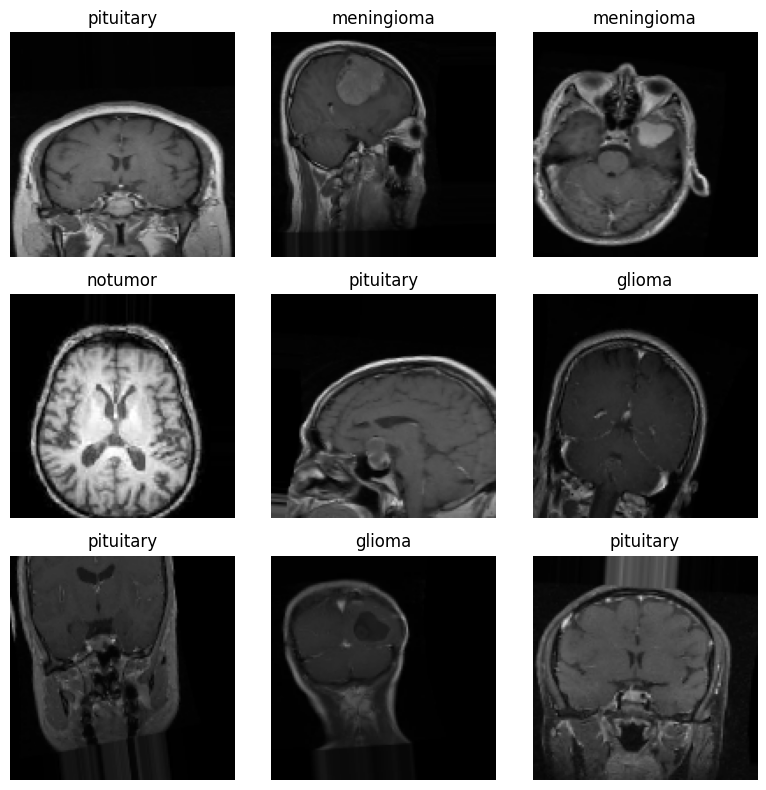

In [ ]:
show_mri(train_ds)

### Model Architecture

In [ ]:
img_shape = (128, 128, 3)
epochs = 20
steps_per_epoch = math.ceil(train_samples / batch_size)
val_steps = math.ceil(val_samples / batch_size)

In [ ]:
base_model = VGG16(input_shape=img_shape, include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

In [ ]:
model = Sequential()
model.add(Input(shape=img_shape))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(class_names), activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 8,128,644 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

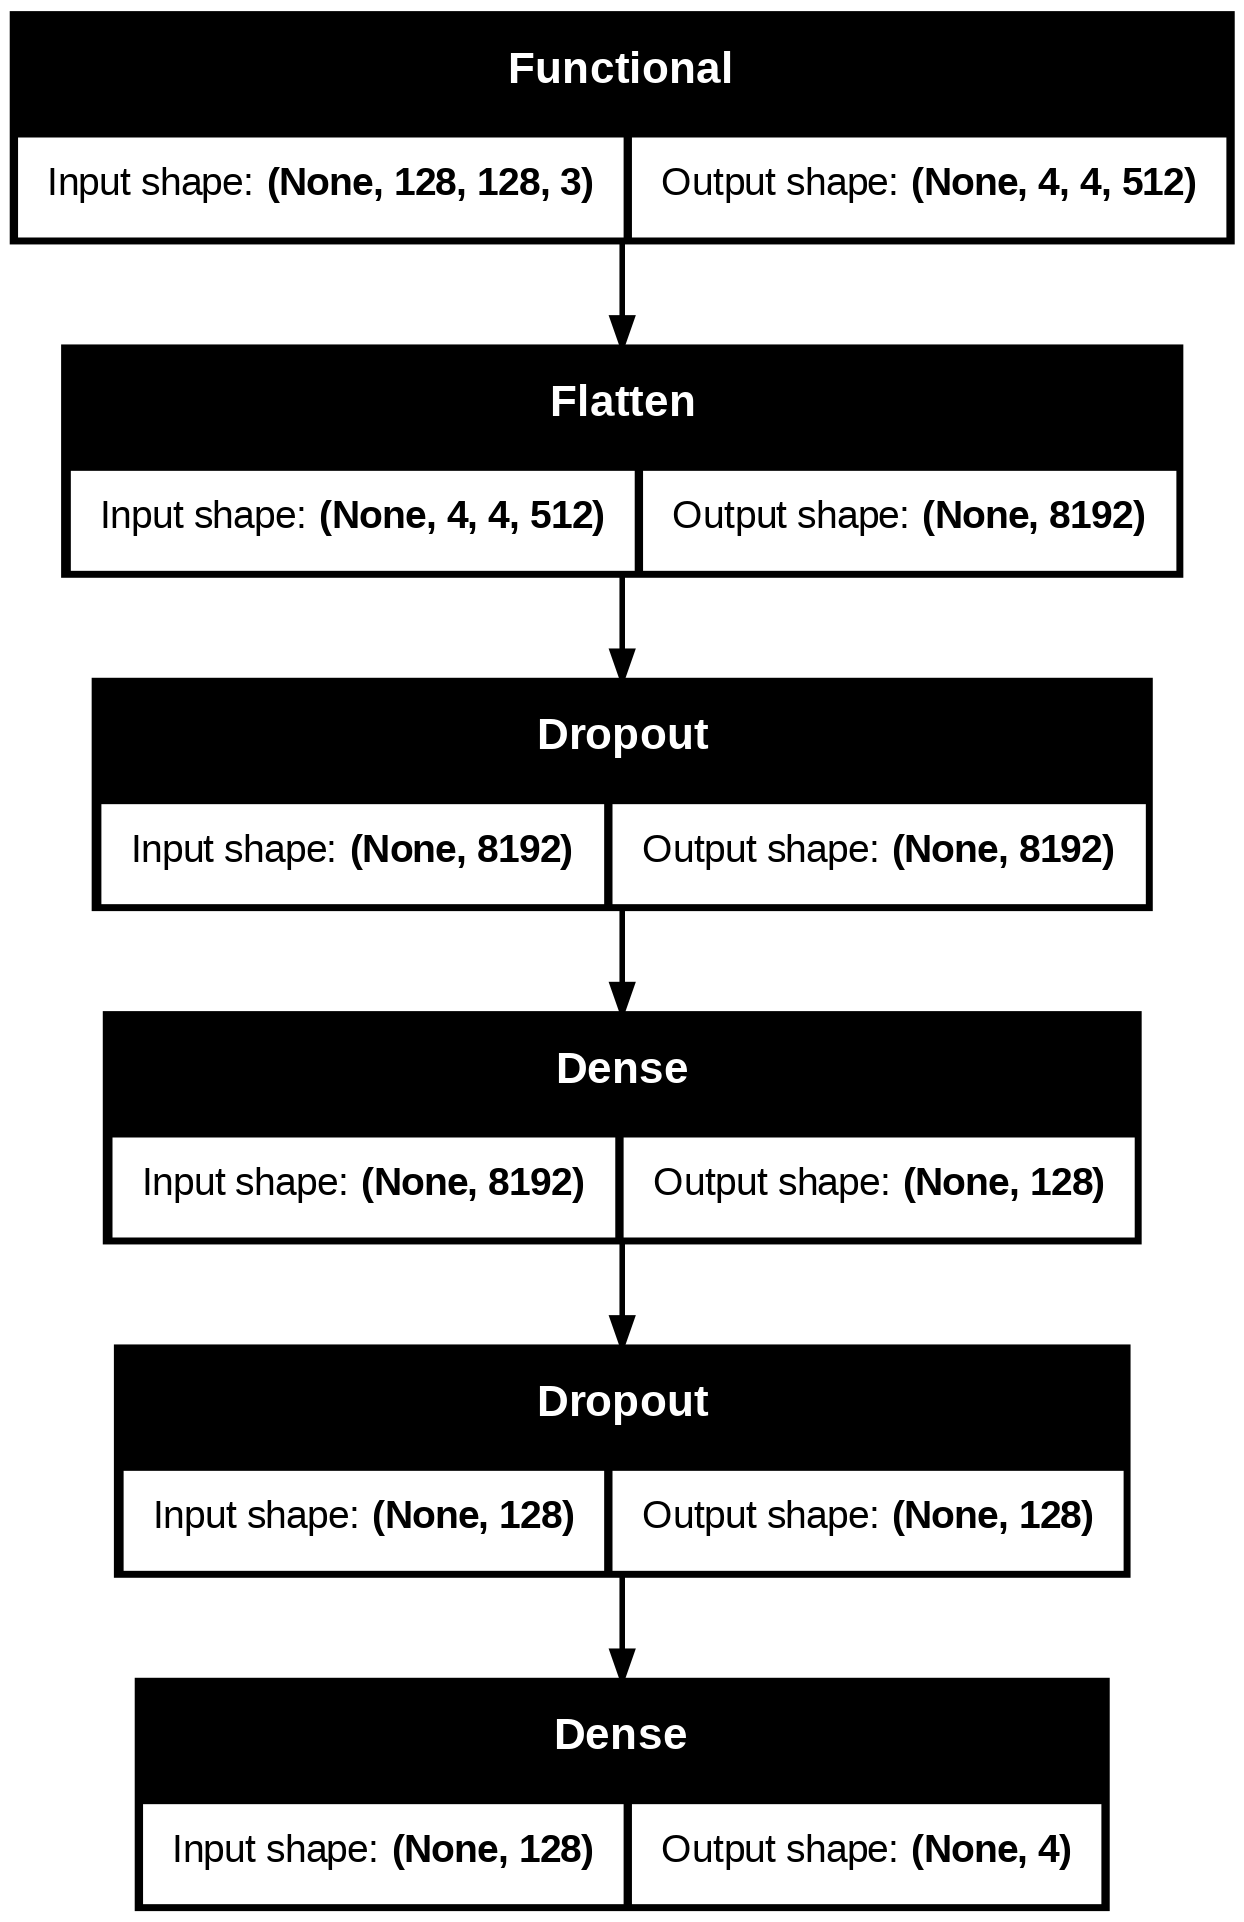

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

### Training

In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=4, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=val_steps,
    epochs=epochs,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 49s 319ms/step - accuracy: 0.6219 - loss: 0.8771 - val_accuracy: 0.7511 - val_loss: 0.6950 - learning_rate: 1.0000e-04
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 42s 294ms/step - accuracy: 0.8531 - loss: 0.3915 - val_accuracy: 0.7695 - val_loss: 0.6862 - learning_rate: 1.0000e-04
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 42s 292ms/step - accuracy: 0.8859 - loss: 0.3186 - val_accuracy: 0.7660 - val_loss: 0.6452 - learning_rate: 1.0000e-04
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 42s 292ms/step - accuracy: 0.8980 - loss: 0.2593 - val_accuracy: 0.7835 - val_loss: 0.6887 - learning_rate: 1.0000e-04
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 42s 293ms/step - accuracy: 0.9155 - loss: 0.2328 - val_accuracy: 0.8291 - val_loss: 0.4861 - learning_rate: 1.0000e-04
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 42s 292ms/step - accuracy: 0.9195 - loss: 0.2218 - val_accuracy: 0.8606 - val_loss: 0.3955 - learning_rate: 1.0000e-04
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 28

In [ ]:
import os

save_dir = '/content/drive/MyDrive/ColabNotebooks/MRI_Brain_Tumor'
model_save_path = os.path.join(save_dir, 'model_best.keras')
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/ColabNotebooks/MRI_Brain_Tumor/model_best.keras


### Evaluation and Visualization

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(12,4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

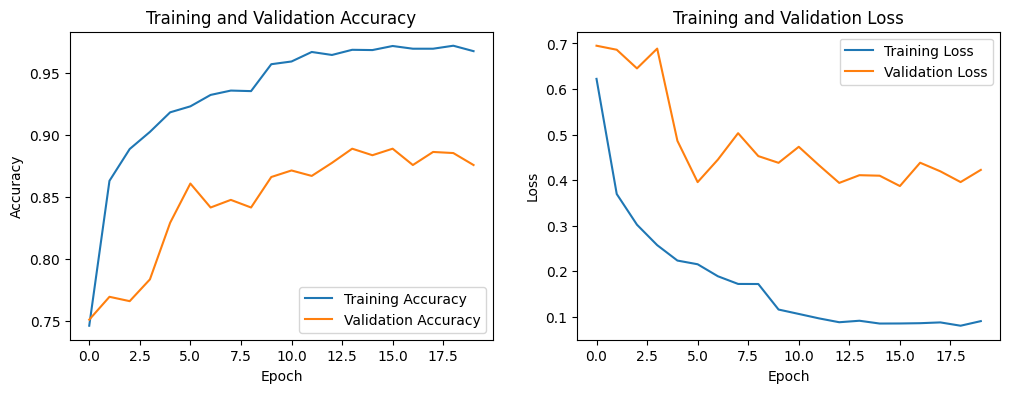

In [ ]:
plot_training_history(history)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.8790 - loss: 0.4104
Test Accuracy: 0.9184
Test Loss: 0.2920


In [ ]:
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_ds.classes

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step


In [ ]:
print(classification_report(y_true, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.95      0.85      0.90       300
  meningioma       0.90      0.84      0.87       306
     notumor       0.97      0.98      0.97       405
   pituitary       0.84      0.99      0.91       300

    accuracy                           0.92      1311
   macro avg       0.92      0.91      0.91      1311
weighted avg       0.92      0.92      0.92      1311



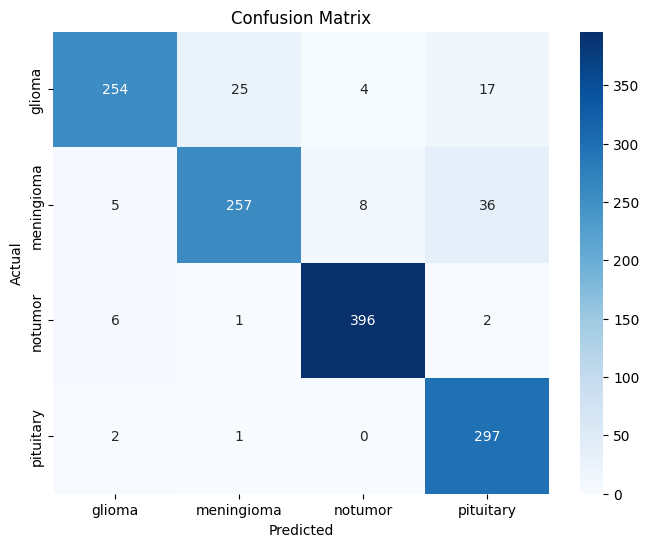

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### LIME Explanation

In [97]:
!pip install lime
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries, quickshift, slic

In [ ]:
def custom_segmentation(image):
    return quickshift(image, kernel_size=1, max_dist=50, ratio=0.05)

In [ ]:
def explain_with_lime(model, images, true_labels, class_names, num_images=5, top_labels=5, num_features=20, hide_color=0, num_samples=2000):
    explainer = lime_image.LimeImageExplainer()

    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 5))
    if num_images == 1:
        axes = axes[np.newaxis, :]

    for i in range(num_images):
        img = images[i]
        true_label = true_labels[i]

        explanation = explainer.explain_instance(
            img.astype('double'),
            model.predict,
            top_labels=top_labels,
            hide_color=hide_color,
            num_samples=num_samples,
            segmentation_fn=custom_segmentation
        )

        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=False,
            num_features=num_features,
            hide_rest=True
        )

        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'True Label: {true_label}')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(mark_boundaries(temp, mask))
        axes[i, 1].set_title('LIME Explanation')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
images, labels = next(test_ds)
true_labels = [class_names[np.argmax(label)] for label in labels]

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

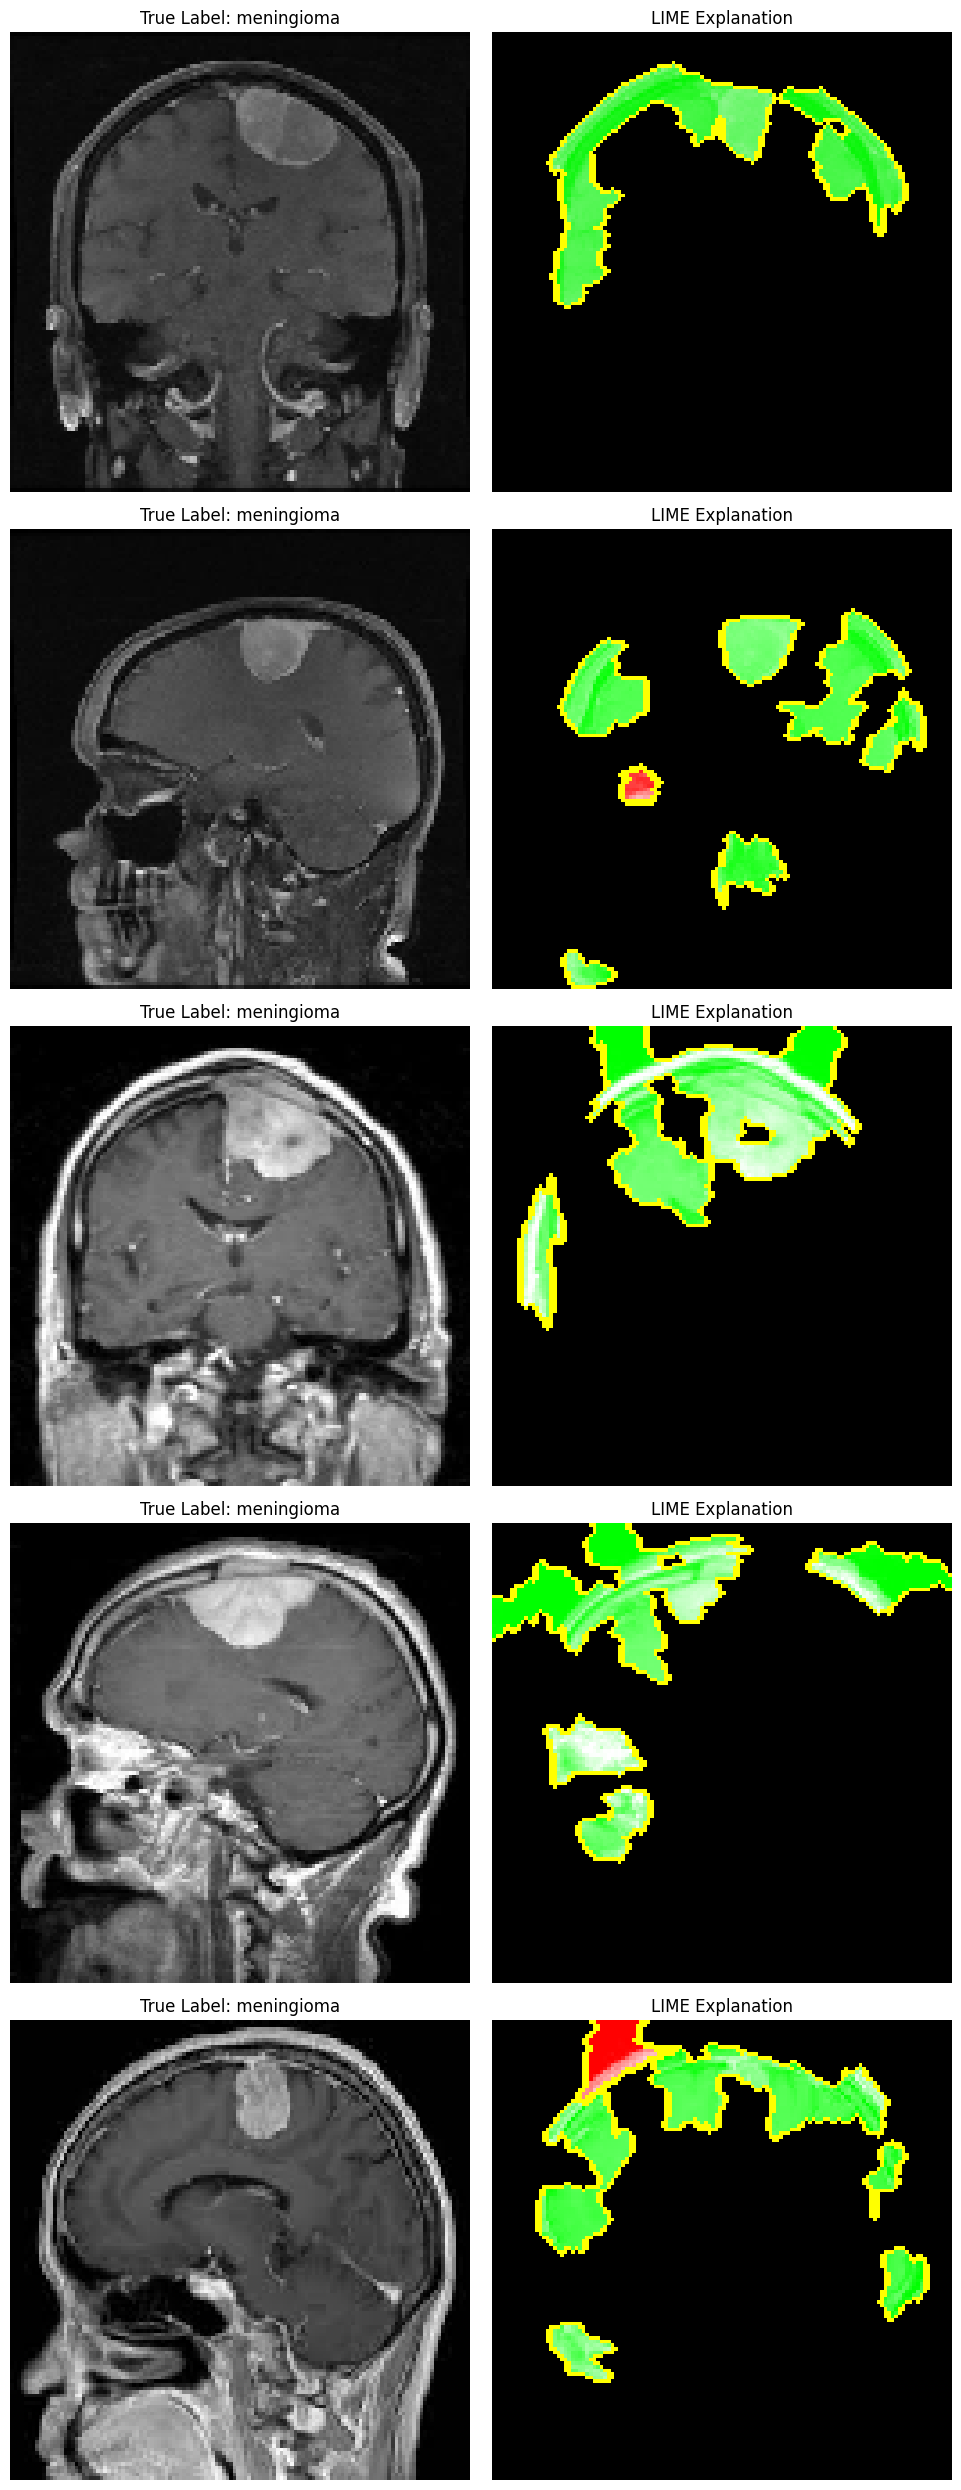

In [205]:
explain_with_lime(
    model=model,
    images=images[:5],
    true_labels=true_labels[:5],
    class_names=class_names,
    num_samples=2000,
    num_features=10
)

### Key Findings from LIME Analysis
- LIME successfully identified relevant regions in all five selected images, demonstrating its effectiveness in explaining the model's predictions.
- Entire Tumor Highlighted: In Figure 2 and Figure 3, LIME highlighted the entire tumor region, indicating that the model correctly identified and focused on the complete tumor area.
- Partial Tumor Highlighted: In the remaining three figures, LIME highlighted only part of the tumor. This could be due to:
  - The tumor's irregular shape or size.
  - The presence of overlapping structures or noise in the image.
  - Limitations in the perturbation process or the interpretable model used by LIME.
- Relevance of Highlighted Regions:
  - The highlighted regions were relevant overall, meaning that the model focused on meaningful features (e.g., tumor regions) rather than irrelevant areas (e.g., background or noise).
  - This indicates that the model is learning to identify important patterns associated with brain tumors, which aligns with the high accuracy achieved.